# RSNA Abdominal Trauma Detection 
### This is my first attempt at a Kaggle Competition hoping to have fun and learn data science, machine learning and gain general experience

# CURRENT AGENDA!!!!!!!
## Stuck on interpretting logits, figure out if the outputs of the model predictions are probability or binary, try to interpret both

# MAIN OBJECTIVE: 
## To identify several potential injuries in CT scans of trauma patients. Any of these injuries can be fatal on a short time frame if untreated so there is great value in rapid diagnosis.

# 1. Imports

In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import os
import pydicom as pyd
from pydicom import filereader
import matplotlib.pyplot as plt

# import tflearn
# from tflearn.layers.conv import conv_2d, max_pool_2d
# from tflearn.layers.core import input_data, dropout, fully_connected
# from tflearn.layers.estimator import regression
# from tflearn.objectives import binary_crossentropy

# 2. Data Investigation

* Train.csv shows each patient's medical history in a multi-class format. Describing which abdominal feature is either healthy/injury or healthy/low/high

* Test/Train images contains the actual CT scanning imagery in DCM format, the standard format for medical scans, which has directories of each patient, with either one or two series that contain instances of scans

* image_labels contain the CT scan labels of the images (instances) that contain either bowel or extravasation injuries.


* IMPORTANT: the directory train_images are structured as [ train_images / patientID / seriesID / image_instance ]

## 2.1 Loading Data

In [3]:
train = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv")
image_labels = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
#   pyd.dcmread() for CT images

In [4]:
train = train.sort_values("patient_id")
train

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
493,19,1,0,1,0,1,0,0,1,0,0,1,0,0,0
866,26,1,0,1,0,1,0,0,1,0,0,1,0,0,0
1268,33,0,1,0,1,1,0,0,0,1,0,1,0,0,1
1788,43,0,1,0,1,1,0,0,1,0,0,1,0,0,1
3129,96,1,0,1,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,65450,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2972,65456,0,1,1,0,1,0,0,1,0,0,0,0,1,1
2973,65495,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2975,65504,1,0,1,0,1,0,0,0,1,0,0,0,1,1


In [5]:
image_labels = image_labels.sort_values(["patient_id","instance_number"])
image_labels

,patient_id,series_id,instance_number,injury_name
4696,33,55570,93,Bowel
4697,33,55570,94,Bowel
4698,33,55570,95,Bowel
4699,33,55570,96,Bowel
4700,33,55570,97,Bowel
...,...,...,...,...
11555,65456,40781,62,Bowel
11556,65456,40781,63,Bowel
11557,65456,40781,64,Bowel
11558,65456,40781,65,Bowel


In [6]:
train = train.reset_index()
train = train.drop(["index"],axis=1)
image_labels = image_labels.reset_index()
image_labels = image_labels.drop(["index"],axis=1)

In [7]:
train

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,19,1,0,1,0,1,0,0,1,0,0,1,0,0,0
1,26,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,33,0,1,0,1,1,0,0,0,1,0,1,0,0,1
3,43,0,1,0,1,1,0,0,1,0,0,1,0,0,1
4,96,1,0,1,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,65450,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3143,65456,0,1,1,0,1,0,0,1,0,0,0,0,1,1
3144,65495,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3145,65504,1,0,1,0,1,0,0,0,1,0,0,0,1,1


In [8]:
image_labels

,patient_id,series_id,instance_number,injury_name
0,33,55570,93,Bowel
1,33,55570,94,Bowel
2,33,55570,95,Bowel
3,33,55570,96,Bowel
4,33,55570,97,Bowel
...,...,...,...,...
12024,65456,40781,62,Bowel
12025,65456,40781,63,Bowel
12026,65456,40781,64,Bowel
12027,65456,40781,65,Bowel


In [9]:
train.mean()

patient_id               32664.239593
bowel_healthy                0.979663
bowel_injury                 0.020337
extravasation_healthy        0.936447
extravasation_injury         0.063553
kidney_healthy               0.942167
kidney_low                   0.036543
kidney_high                  0.021290
liver_healthy                0.897998
liver_low                    0.082301
liver_high                   0.019701
spleen_healthy               0.887512
spleen_low                   0.063235
spleen_high                  0.049253
any_injury                   0.271687
dtype: float64

# 3. Basic Pre-processing
* In this section we plan to perform some optimizations such as,
* recropping any dead space in the image such that every pixel counts in the image,
* standardization for pixel representation

## 3.1 Optimizing CT image access
* adds a path to image_labels which initally shows the labels, relevant to the CT scans in train/test_images, to the images themselves.

/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/33/55570/93.dcm


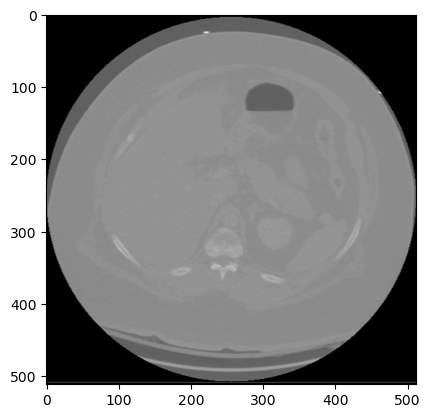

In [10]:
def train_CT_img_path(row):
    return f"/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/{row['patient_id']}/{row['series_id']}/{row['instance_number']}.dcm"

image_labels['img_path'] = image_labels.apply(train_CT_img_path, axis=1)
print(image_labels.loc[0,'img_path'])
instance = pyd.dcmread(image_labels.loc[0, 'img_path'])
plt.imshow(instance.pixel_array, cmap='gray')

In [11]:
image_labels

,patient_id,series_id,instance_number,injury_name,img_path
0,33,55570,93,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
1,33,55570,94,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
2,33,55570,95,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
3,33,55570,96,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
4,33,55570,97,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
...,...,...,...,...,...
12024,65456,40781,62,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
12025,65456,40781,63,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
12026,65456,40781,64,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
12027,65456,40781,65,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...


## 3.2 Recropping removing unused pixel data

In [12]:
import cv2
crop_size = 250
img_size = 75
def crop_img(img):
    img = img.astype("uint8")
#     blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     plt.imshow(mask, cmap="gray")
    cnts, _ = cv2.findContours(mask.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(cnt)
    return (x,y,w,h)

def standardize_img(img):
    # input: dcmread img
    pixel_arr = img.pixel_array
    return np.array(pixel_arr)

def center_crop(img, dim):
	"""Returns center cropped image
	Args:
	img: image to be center cropped
	dim: dimensions (width, height) to be cropped
	"""
	width, height = img.shape[1], img.shape[0]

	# process crop width and height for max available dimension
	crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
	crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
	mid_x, mid_y = int(width/2), int(height/2)
	cw2, ch2 = int(crop_width/2), int(crop_height/2) 
	crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	return crop_img

def preprocess(instance, dcm_val=True):
    #For images of type DCM ct scans
    if dcm_val:
        img = pyd.dcmread(instance)
        img = standardize_img(img)
        x,y,w,h = crop_img(img)
        img = img[y:(y+h), x:(x+w)]
        img = center_crop(img,(crop_size,crop_size))
        img = cv2.resize(img,(img_size,img_size))
    #images of type png/jpeg
    else:
        img = cv2.imread(instance)
        cv2.imshow("image,",img)
#         img = standardize_img(img)
        x,y,w,h = crop_img(img)
        img = img[y:(y+h), x:(x+w)]
        img = center_crop(img,(crop_size,crop_size))
        img = cv2.resize(img,(img_size,img_size))
    return img

## before and aftger preprocesssing

In [13]:
# plotn = 3
# f, axarr = plt.subplots(plotn, 2)
# patient_index = train.loc[2,"patient_id"]
# f.set_figheight(plotn/2*8)
# f.set_figwidth(6)
# for i in range(plotn):
#     inst = image_labels.loc[(image_labels["patient_id"]==patient_index),"img_path"][i]
#     print(inst)
#     axarr[i][1].imshow(preprocess(inst,True), cmap='gray')
#     axarr[i][0].imshow(pyd.dcmread(inst).pixel_array, cmap='gray')


# for ax, col in zip(axarr[0], ['BASE', 'PREPROCESSED']):
#     ax.set_title(col, color='red')
    



## CNN image classification for injuries,
### Classes include:
[ bowel_healthy  	   bowel_injury	extravasation_healthy	extravasation_injury	kidney_healthy	kidney_low	kidney_high	liver_healthy	liver_low	liver_high	spleen_healthy	spleen_low	spleen_high	] 

in a multi-binary format

[1,0,1,0,1,0,0,1,0,0,1,0,0] = healthy patient no injury

[0,1,1,0,1,0,0,1,0,0,1,0,0] = patient with bowel injury

1 healthy and 0 unhealthy

At this moment my idea makes most sense for my cnn to learn each patient individually and provide rapid diagnosis

But try and investigate how to make a general purpose model that learns instances across multiple patients




## Loading Data in X to be train on by a ML model

### Splitting Training and Test Data

In [14]:
print(image_labels["injury_name"].value_counts())

Active_Extravasation    6370
Bowel                   5659
Name: injury_name, dtype: int64


<Axes: ylabel='injury_name'>

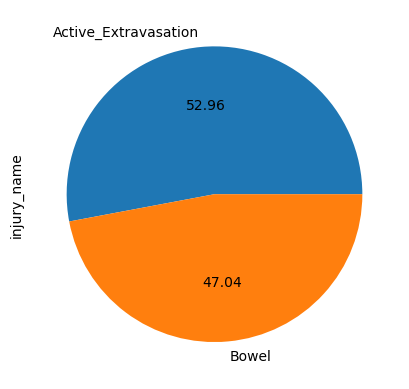

In [15]:
image_labels["injury_name"].value_counts().plot.pie(autopct="%.2f")

not too bad

In [16]:
data_size = len(image_labels)
print(data_size)

12029


## Produce X_data

In [17]:
# X_data = []
# # CT scans 
# # FIX THIS CODE SO IT PROCDUCES CORRECT LEARNING DATA
# for image in range(data_size):
#     if image%100==0:
#         print(image)
# #     print(image_labels.loc[image,"img_path"])
#     img = preprocess(image_labels.loc[image, 'img_path'])
#     img = img/255
#     X_data.append(img)
# np.save("/kaggle/working/X_data.npy",X_data )

## Binary classifciaton for a bowel or active extravastion

In [18]:
# Y_data = []
# for injury in image_labels["injury_name"]:
#     if injury == "Active_Extravasation":
#         Y_data.append([1,0])
#     elif injury == "Bowel":
#         Y_data.append([0,1])
# # Y_data = Y_data[:int(train["patient_id"].size)]
# print(Y_data.__len__())

In [19]:
train_labels = train.drop(["any_injury"],axis=1)

In [20]:
patient_count = image_labels.groupby('patient_id')['patient_id'].count()
print(train_labels["patient_id"])


0          19
1          26
2          33
3          43
4          96
        ...  
3142    65450
3143    65456
3144    65495
3145    65504
3146    65508
Name: patient_id, Length: 3147, dtype: int64


## Making the Y labels each patients trauma injuries

add label per patient

In [21]:
Y_data = []
print(len(train_labels))
for index in range(len(train_labels)):
    #Grabs the multi-class labels in a single list
    tmp = []
    for label in train_labels.loc[index]:
        tmp.append(label+0.0)
    #We multiply the single multi-class label by the amount of occurances of the patient_id
    tmp.pop(0)
    try:
        for i in range(patient_count[train_labels["patient_id"][index]]):
            Y_data.append(tmp)
    except:
        pass

# print(train_labels.loc[0][1])
print("done!")

3147
done!


In [22]:
print(patient_count)

patient_id
33       36
43       53
263      12
820      71
1675      1
         ..
64091     9
64194    74
64256    22
64501    19
65456    16
Name: patient_id, Length: 246, dtype: int64


In [23]:
Y_data = np.array(Y_data)
print(Y_data.shape)
if img_size == 50:
    X_data = np.load("/kaggle/input/atd-processed-x-data/X_data.npy")
elif img_size == 75:
    X_data = np.load("/kaggle/input/x-data75by75/X_data_70by70.npy")
print(X_data.shape)

(12029, 13)
(12029, 75, 75)


In [24]:
print(len(Y_data[1]))
print(image_labels.loc[1,"img_path"])

13
/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/33/55570/94.dcm


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_data,Y_data,test_size=0.1)

test_size = 20

X_train = X_train.reshape(-1,img_size,img_size,1)
X_val = X_val.reshape(-1,img_size,img_size,1)

X_test = []
Y_test = []
for index in range(test_size):
    rand_sample = np.random.randint(low=0,high=len(X_train))
    X_test.append(X_train[rand_sample])
    X_train = np.delete(X_train, rand_sample, 0)
    Y_test.append(Y_train[rand_sample])
    Y_train = np.delete(Y_train, rand_sample, 0)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
print(X_train.shape,X_val.shape)
print(Y_train.shape,Y_val.shape)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(10806, 75, 75, 1) (1203, 75, 75, 1)
(10806, 13) (1203, 13)


# Convoluational Neural Network

## TFLearn

In [26]:
# # # 64, 64, 32 = 0.7-0.76
# !pip install tflearn
# import tflearn
# from tflearn.layers.conv import conv_2d, max_pool_2d
# from tflearn.layers.core import input_data, dropout, fully_connected
# from tflearn.layers.estimator import regression
# from tflearn.objectives import binary_crossentropy

# convnet = input_data(shape=[None,img_size,img_size,1], name='input')

# convnet = conv_2d(convnet, 32, 2, activation='relu')
# convnet = max_pool_2d(convnet, 2)

# convnet = conv_2d(convnet, 64, 2, activation='relu')
# convnet = max_pool_2d(convnet, 2)

# convnet = conv_2d(convnet, 64, 2, activation='relu')
# convnet = max_pool_2d(convnet, 2)

# convnet = fully_connected(convnet, 2048, activation='relu')
# convnet = dropout(convnet, 0.3)

# convnet = fully_connected(convnet, 13, activation='sigmoid')
# model = regression(convnet, optimizer='adam', learning_rate=1e-3, loss=binary_crossentropy, name='targets')

# model = tflearn.DNN(model)

# model.fit({'input': X_train}, {'targets': Y_train},
#           n_epoch=20,
#           shuffle=True,
#           validation_set=({'input': X_test}, {'targets': Y_test}),
#           show_metric=True,
#           snapshot_step=500,
#           run_id="ATD-CNN-Model")

## KERAS

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 37, 37, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 37, 37, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0

2023-09-03 15:25:22.809085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


338/338 [==============================] - 11s 10ms/step - loss: 0.5300 - binary_accuracy: 0.7524 - val_loss: 0.4380 - val_binary_accuracy: 0.8045
Epoch 2/25
338/338 [==============================] - 3s 9ms/step - loss: 0.4435 - binary_accuracy: 0.7982 - val_loss: 0.4041 - val_binary_accuracy: 0.8149
Epoch 3/25
338/338 [==============================] - 3s 8ms/step - loss: 0.4103 - binary_accuracy: 0.8120 - val_loss: 0.3680 - val_binary_accuracy: 0.8316
Epoch 4/25
338/338 [==============================] - 3s 8ms/step - loss: 0.3805 - binary_accuracy: 0.8286 - val_loss: 0.3263 - val_binary_accuracy: 0.8504
Epoch 5/25
338/338 [==============================] - 3s 8ms/step - loss: 0.3514 - binary_accuracy: 0.8446 - val_loss: 0.2963 - val_binary_accuracy: 0.8640
Epoch 6/25
338/338 [==============================] - 3s 8ms/step - loss: 0.3202 - binary_accuracy: 0.8588 - val_loss: 0.2502 - val_binary_accuracy: 0.8861
Epoch 7/25
338/338 [==============================] - 3s 8ms/step - loss:

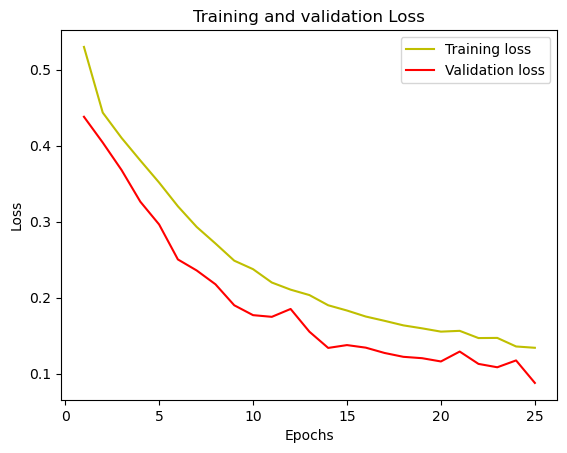

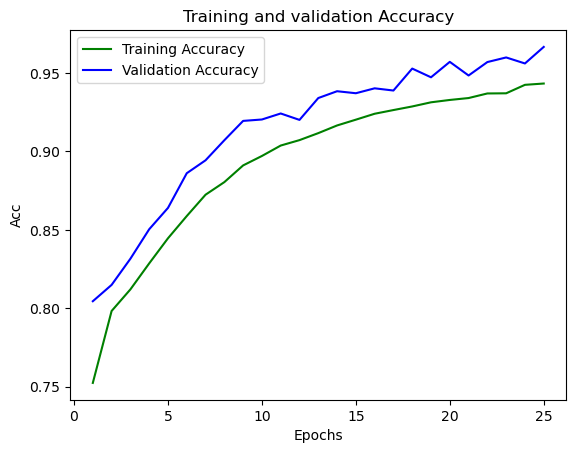

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.metrics import binary_accuracy
from keras.losses import BinaryCrossentropy
BinaryCrossentropy = BinaryCrossentropy()
from keras.layers import BatchNormalization
k_size = 5
opt = Adam(learning_rate=1e-3)
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(k_size, k_size), activation="relu", input_shape=(img_size,img_size,1), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(k_size, k_size), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(k_size, k_size), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(k_size, k_size), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))


#Do not use softmax for multilabel classification
#Softmax is useful for mutually exclusive classes, either cat or dog but not both.
#Also, softmax outputs all add to 1. So good for multi class problems where each
#class is given a probability and all add to 1. Highest one wins. 

#Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
#like multi label, in this example.
#But, also good for binary mutually exclusive (cat or not cat). 

model.summary()

#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. 
model.compile(optimizer=opt, loss=BinaryCrossentropy, metrics=['binary_accuracy'])

history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_val, Y_val))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
plt.plot(epochs, acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

## Saving/Loading Model

In [28]:
# model.save("/kaggle/working/ATD_model")
# model.load("/kaggle/input/nn-model/ATD_model")

In [29]:
print(X_test.shape)
print(X_val[0].shape)

(20, 75, 75, 1)
(75, 75, 1)


# Experiments and Test Cases

In [30]:
num_of_test_cases = 5
diagnosis_labels = train_labels.loc[(train_labels["patient_id"]==0)].axes[1]
diagnosis_labels = diagnosis_labels.drop(["patient_id"])

for i in range(num_of_test_cases):
    test = []
    test.append(X_test[i].tolist())
    pred = model.predict(test)

    print(i)
    pred = pred.round(3)
    print("Pred",pred[0])
    label = Y_test[i]
    print("Label",label)
    actual_diag = []
    for index in range(len(diagnosis_labels.values)):
        print(diagnosis_labels.values[index],": ", (pred[0][index]*100),"%")
        if tmp[index] == (1+0.0):
            actual_diag.append(diagnosis_labels.values[index])




1/1 [==============================] - 0s 233ms/step
0
Pred [0.055 0.945 0.701 0.299 0.88  0.023 0.074 0.423 0.573 0.001 0.815 0.045
 0.171]
Label [0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
bowel_healthy :  5.499999970197678 %
bowel_injury :  94.49999928474426 %
extravasation_healthy :  70.09999752044678 %
extravasation_injury :  29.899999499320984 %
kidney_healthy :  87.99999952316284 %
kidney_low :  2.3000000044703484 %
kidney_high :  7.400000095367432 %
liver_healthy :  42.30000078678131 %
liver_low :  57.30000138282776 %
liver_high :  0.10000000474974513 %
spleen_healthy :  81.49999976158142 %
spleen_low :  4.500000178813934 %
spleen_high :  17.100000381469727 %
1/1 [==============================] - 0s 33ms/step
1
Pred [0.    1.    0.985 0.014 0.921 0.069 0.    0.159 0.837 0.    0.042 0.66
 0.188]
Label [0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
bowel_healthy :  0.0 %
bowel_injury :  100.0 %
extravasation_healthy :  98.50000143051147 %
extravasation_injury :  1.4000000432133675 %
kidn

In [31]:
# num_of_test_cases = 5
# test_cases = {}
# for n in range(num_of_test_cases):
#     rand_case = np.random.randint(low=0, high=len(X_val))
#     test_cases[n] = image_labels.loc[rand_case,"img_path"]
# diagnosis_labels = train_labels.loc[(train_labels["patient_id"]==0)].axes[1]
# diagnosis_labels = diagnosis_labels.drop(["patient_id"])


# # f, axarr = plt.subplots(nrows=num_of_test_cases)

# # f.set_figheight(num_of_test_cases*8)
# # f.set_figwidth(8)
# # f.tight_layout(pad=5.0)
    
# for i in range(num_of_test_cases):
    
#     img_path = test_cases.get(i)

# #     axarr[i].imshow(pyd.dcmread(img_path).pixel_array, cmap='gray')
    
#     raw_img = preprocess(img_path,True)
    
#     img = raw_img.reshape(-1,img_size,img_size,1)
#     pred = model.predict(img)
# #     pred = model.predict(X_test[i])

#     print(i)
# #     print("Pred",pred[0])
#     pred = pred.round(3)
#     print("Pred",pred[0])
#     patient_id = image_labels.loc[(image_labels["img_path"]==img_path),"patient_id"].values[0]
#     label = train_labels.loc[(train_labels["patient_id"]==patient_id)].values[0]
# #     label = Y_test[i]
#     tmp = []
#     for value in label:
#         tmp.append(value)
#     tmp.pop(0)
#     print("Label",tmp)
#     actual_diag = []
#     for index in range(len(diagnosis_labels.values)):
#         print(diagnosis_labels.values[index],": ", pred[0][index])
#         if tmp[index] == (1+0.0):
#             actual_diag.append(diagnosis_labels.values[index])
# #     predic_diag = []
# #     for index in range(len(diagnosis_labels.values)):
# #         if pred[0][index] > 0.5:
# #             predic_diag.append(diagnosis_labels.values[index])
    
    
# #     train_labels.loc[(train_labels["patient_id"]==patient_id)]
# #     axarr[i].set(title="\nCase: {} \nLabel:   {} \nPrediction: {}\n Probs: {}\n".format(i+1,actual_diag,predic_diag, pred))



In [32]:
import csv
test_images = {}
test_img1 = "/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/48843/62825/30.dcm"
test_img2 = "/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/50046/24574/30.dcm"
test_img3 = "/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/63706/39279/30.dcm"
test_images[0] = test_img1
test_images[1] = test_img2
test_images[2] = test_img3
output = []
for i in range(test_images.__len__()):
    
    img_path = test_images[i]
    img = preprocess(img_path,True)
    img = img.reshape(-1, img_size, img_size, 1)
    pred = model.predict(img)
    output.append(pred)
    print("Test_image: {}\nPred: {}\n".format(i,pred[0]))
#     for index in range(len(diagnosis_labels.values)):
#         print(diagnosis_labels.values[index],": ", pred[0][index])
print(output)
    
    

1/1 [==============================] - 0s 140ms/step
Test_image: 0
Pred: [1.0000000e+00 1.6773573e-30 0.0000000e+00 1.0000000e+00 1.0000000e+00
 1.1268729e-10 2.7761402e-10 2.0153559e-06 8.9997187e-04 9.9999368e-01
 1.0000000e+00 2.0392306e-18 1.4312783e-08]

1/1 [==============================] - 0s 139ms/step
Test_image: 1
Pred: [1.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00
 1.8124467e-36 3.6023737e-23 4.1573887e-18 6.3364589e-17 1.0000000e+00
 1.0000000e+00 0.0000000e+00 1.1781094e-28]

1/1 [==============================] - 0s 19ms/step
Test_image: 2
Pred: [1.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00
 2.1011370e-20 1.8201115e-19 2.4635417e-11 2.2843610e-06 1.0000000e+00
 1.0000000e+00 1.4011504e-34 3.8637209e-16]

[array([[1.0000000e+00, 1.6773573e-30, 0.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.1268729e-10, 2.7761402e-10, 2.0153559e-06,
        8.9997187e-04, 9.9999368e-01, 1.0000000e+00, 2.0392306e-18,
        1.431278

# SUBMISSION TESTING
### these are the labels for the test data images

In [33]:
df_sub = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/sample_submission.csv")
df_sub

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [34]:

df_col = df_sub.columns.drop("patient_id")
for patient in range(df_sub["patient_id"].size):
    for value in range(df_col.size):
        df_sub.loc[patient,df_col[value]] = output[patient][0][value]
df_sub.to_csv("submission.csv",index=False)
df_sub

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,1.0,1.677357e-30,0.0,1.0,1.0,1.126873e-10,2.776140e-10,2.015356e-06,8.999719e-04,0.999994,1.0,2.039231e-18,1.431278e-08
1,50046,1.0,0.000000e+00,0.0,1.0,1.0,1.812447e-36,3.602374e-23,4.157389e-18,6.336459e-17,1.000000,1.0,0.000000e+00,1.178109e-28
2,63706,1.0,0.000000e+00,0.0,1.0,1.0,2.101137e-20,1.820112e-19,2.463542e-11,2.284361e-06,1.000000,1.0,1.401150e-34,3.863721e-16
